# Tutorial: Expression analysis with rnalib, archs4 and genemunge

This notebook contains two parts:

In part 1, we:

* Instatiate the human transcriptome containing protein coding genes with rnalib to extract gene length and exon counts
* Use genemunge to get a list of housekeeping genes, recount2 expression values and Hellinger distance values
* Plot the data


In part 2, we:
* Use rnalib's archs4 interface to get archs4 data (requires download of large data file)


First, we install [genemunge](https://github.com/unlearnai/genemunge) a python package for accessing GTex/recount2 data. NOTE that installation of this package requires hdf5 to be installed. See [here](https://stackoverflow.com/questions/73029883/could-not-find-hdf5-installation-for-pytables-on-m1-mac) for installation via homebrew on MacOS.

In [1]:
#%pip install genemunge

Now we can load all required packages.

In [1]:
import os, pathlib, platform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import genemunge
import seaborn as sns

# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea
plt.rcParams["figure.figsize"] = (20,3)

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

'Running rnalib 0.0.2 on python 3.12.1'

#### Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [2]:
if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                                 rna.testdata.large_test_resources)
else:
    display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
    display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Testdata at rnalib_testdata/'

# Part 1: rnalib and genemunge
First, we build subset of human transcriptome containing only canonical, protein coding genes.

In [3]:
t=rna.Transcriptome(
    annotation_gff=rna.get_resource("full_gencode_gff"),
    annotation_flavour='gencode',
    feature_filter=rna.TranscriptFilter().include_tags(['Ensembl_canonical']).include_gene_types(['protein_coding'])
)
t

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/19982 [00:00<?, ?it/s]

Transcriptome with 19982 genes and 74981 tx

Using genemunge, we retrieve a list of housekeeping genes, see see https://www.tau.ac.il/~elieis/HKG/

In [4]:
searcher = genemunge.search.Searcher()
housekeeping_genes = searcher.get_housekeeping_genes()
print(f'Identified {len(housekeeping_genes)} housekeeping genes')

Identified 3620 housekeeping genes


Now, we can compile tissue-specific expression data for housekeeping and all other genes as
well as some gene-related values (average number of exons per tx, gene length).
We exemplary show data for three tissues ('Blood', 'Bone Marrow', 'Brain'), the expression values are tpm normalized.
Using the transcriptomer model, we can easily access gene length and average number of exons (which naturally correlate) for a downstream analysis.

In [5]:
def get_exp_data(t, genes, housekeeping_genes, tissues=('Blood',)):
    # set up an object to describe genes
    describer = genemunge.describe.Describer('symbol')
    # get major versions of gene ids
    ids = [g.feature_id.split('.')[0] for g in genes]
    # create dataframe
    expression_data = pd.DataFrame(index=ids, columns=['hellinger', 'len', 'n_exon', 'HK']+[f"exp_{tissue}" for tissue in tissues])
    expression_data['len'] = [len(g) for g in genes] # get gene lengths
    expression_data['n_exon'] = [np.mean([len(tx.exon) for tx in g.transcript]) for g in genes] # get mean #exons per gene
    # get the expression levels in healthy tissue (in TPM units)
    for tissue in tissues:
        expression_data[f"exp_{tissue}"] = describer.tissue_stats['median'].reindex(ids)[tissue]
    # get the hellinger distance 
    expression_data['hellinger'] = describer.tissue_stats['hellinger'].reindex(ids)
    # is it a HK gene?
    expression_data['HK']=['yes' if g.feature_id.split('.')[0] in housekeeping_genes else 'no' for g in genes]
    return expression_data

# get expression levels of each gene of interest
tissues=('Blood', 'Bone Marrow', 'Brain')
exp = get_exp_data(t, t.genes, housekeeping_genes, tissues)
exp.describe(include='all')

,hellinger,len,n_exon,HK,exp_Blood,exp_Bone Marrow,exp_Brain
count,19640.000000,1.998200e+04,19982.000000,19982,19640.000000,19640.000000,19640.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,no,NaN,NaN,NaN
freq,NaN,NaN,NaN,16374,NaN,NaN,NaN
mean,0.970893,6.877190e+04,6.351230,NaN,34.773819,33.032600,34.321095
std,0.049021,1.329786e+05,5.142015,NaN,1824.817139,386.487213,963.890137
min,0.339648,3.900000e+01,1.000000,NaN,0.000000,0.000000,0.000000
25%,0.963851,9.741000e+03,3.500000,NaN,0.067002,0.089170,0.490639
50%,0.987020,2.743100e+04,5.250000,NaN,1.147619,3.912210,3.808928
75%,0.998689,7.164075e+04,7.750000,NaN,6.222931,19.721184,11.014380


Now, we plot the tissue-specific expression and the Hellinger distance for housekeeping genes 
vs all others. 

Text(0.5, 0.98, 'Tissue specific expression and Hellinger distance, all vs HK genes')

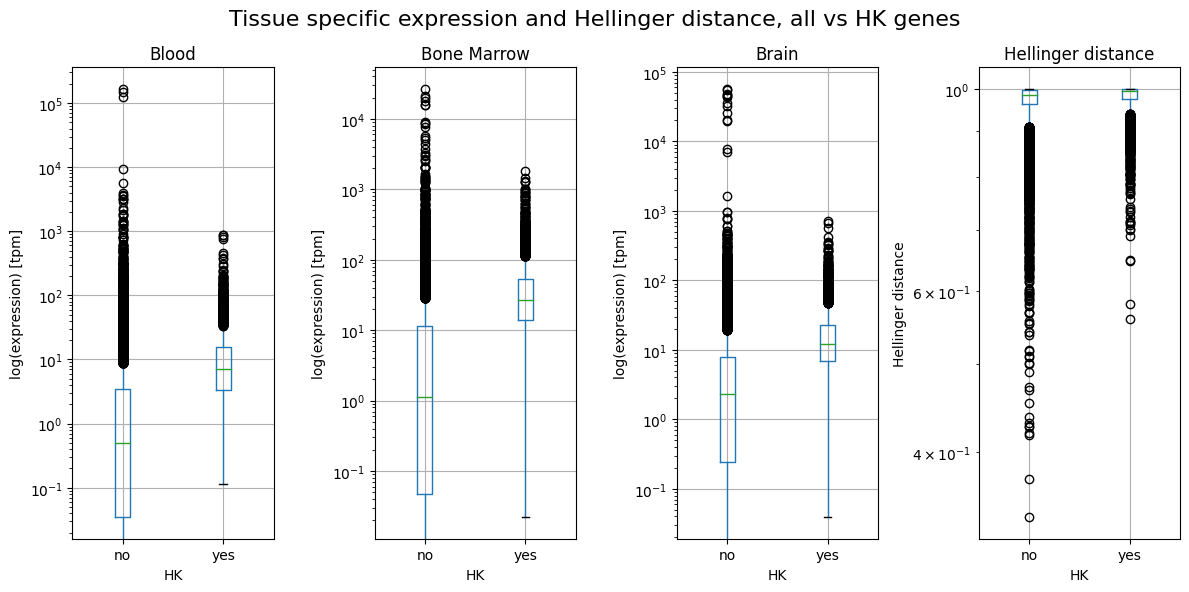

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
for i, tissue in enumerate(tissues):
    exp.boxplot(column=f"exp_{tissue}", by='HK', ax=ax[i])
    ax[i].set_yscale('log')
    ax[i].set_ylabel('log(expression) [tpm]')
    ax[i].set_title(tissue)
exp.boxplot(column='hellinger', by='HK', ax=ax[-1])
ax[-1].set_yscale('log')
ax[-1].set_title('Hellinger distance')
ax[-1].set_ylabel('Hellinger distance')
fig.tight_layout()
fig.suptitle(t='Tissue specific expression and Hellinger distance, all vs HK genes', fontsize=16)

As expected, housekeeping genes have higher expression levels. They also show higher
Hellinger distance values which range between 0 (all tissues have the same expression) and 1 (at least one tissue pair are easily distinguished).

Now, we plot the Hellinger distance vs number of exons and vs gene length. 

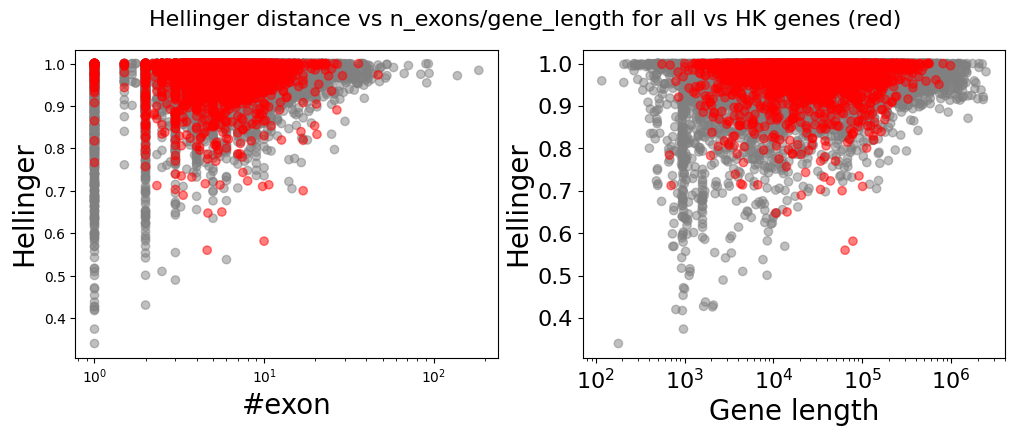

In [7]:
# plot hellinger distance vs gene length
exp=exp.sort_values('HK')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.scatter(exp['n_exon'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax1.set_xlabel('#exon', fontsize=20)
ax1.set_xscale('log')
ax1.set_ylabel('Hellinger', fontsize=20)

ax2.scatter(exp['len'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax2.set_xlabel('Gene length', fontsize=20)
ax2.set_xscale('log')
ax2.set_ylabel('Hellinger', fontsize=20)

fig.suptitle(t='Hellinger distance vs n_exons/gene_length for all vs HK genes (red)', fontsize=16);
plt.show()

Longer genes have higher Hellinger distance.

# Part 2: rnalib and archs4

First, we need to download an h5 file from archs4:

In [8]:
archs4_test_resources = {'human_gene_v2.2': {
    'uri': 'https://s3.dev.maayanlab.cloud/archs4/files/human_gene_v2.2.h5',
    'filename': 'bigfiles/human_gene_v2.2.h5',
    'recreate': False}}
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, archs4_test_resources)
# access file with rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)

============= Output directory: rnalib_testdata/=========


Creating testdata:   0%|          | 0/1 [00:00<?, ?it/s]

Creating testdataset human_gene_v2.2
Resource already exists, skipping...
========= All done with 0 errors  ==========


Now we can query for datasets...

In [9]:
# query the dataset for samples
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    # a4.describe() # show some sampled data
    # query recent HiSeq datasets with sufficient reads
    df = a4.get_sample_metadata(filter_string = "readsaligned>5000000 & instrument_model.str.contains('HiSeq')") 

  0%|          | 0/468 [00:00<?, ?it/s]

INFO:root:Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


Data is in a local dataframe now and we can query it with pandas 

In [10]:
# now, we have a local dataframe and can get familiar with the data
display("Here are the used instruments:", set(df.instrument_model))
display(SEP, "Here are the GEO series with most associated samples:")
df.groupby('series_id').size().reset_index(name='counts').\
    sort_values('counts', ascending=False).head()

'Here are the used instruments:'

{'HiSeq X Ten',
 'Illumina HiSeq 1000',
 'Illumina HiSeq 1500',
 'Illumina HiSeq 2000',
 'Illumina HiSeq 2500',
 'Illumina HiSeq 3000',
 'Illumina HiSeq 4000'}

---

'Here are the GEO series with most associated samples:'

,series_id,counts
7769,GSE193677,2484
281,GSE103147,1594
7170,GSE183635,1502
9014,"GSE47774,GSE47792",1366
6740,GSE177040,1332


In [11]:
# lets get the counts for a random sample of our dataframe
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    df_cnt = a4.get_counts(samples = df.sample(5).index) 
df_cnt

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSG00000290126,ENSG00000290127,ENSG00000290146,ENSG00000290147,ENSG00000290149,ENSG00000290162,ENSG00000290163,ENSG00000290164,ENSG00000290165,ENSG00000290166
GSM2740830,308,1,933,542,297,24,869,304,2090,1248,...,24,24,116,0,0,1,5,3,3,0
GSM3100304,3844,1,781,996,116,450,5007,1294,5641,729,...,11,1,82,0,0,0,0,0,0,1
GSM3743492,525,1,1041,334,544,0,463,1070,1138,543,...,50,6,170,0,0,0,0,0,0,0
GSM4987875,694,0,1378,191,575,28,163,2826,1530,787,...,27,8,314,0,0,0,1,0,2,17
GSM6619163,11,0,895,59,17,8032,4,1681,2612,221,...,0,1,329,0,0,0,0,0,1,3


In [12]:
# annotate housekeeping genes in transcriptome
for g in t.genes:
    # get major versions of gene ids
    maj = g.feature_id.split('.')[0]
    t[g]['housekeeping_gene'] = maj in housekeeping_genes
hkg = [g for g in t.genes if g.housekeeping_gene]

In [13]:
# get counts for 1k random samples but for housekeeping genes only. 
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    df_cnt = a4.get_counts(samples=df.sample(1000).index, gene_symbols=[g.gene_name for g in hkg]) 
df_cnt

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


,DPM1,SCYL3,GCLC,BAD,LAP3,M6PR,ALS2,RBM5,ARF5,POLDIP2,...,PPFIA1,PEX5,CC2D1A,MCTS1,LDHA,GPS2,CTTN,UBL7,CYFIP1,PRKACA
GSM1100208,6463,1005,2290,2607,17620,20983,3438,5656,7726,6165,...,836,986,1016,2344,22470,3452,6112,677,4086,2844
GSM1157408,217,76,293,80,337,578,833,896,605,583,...,66,129,92,131,1992,124,514,123,140,150
GSM1157677,133,73,292,212,251,399,1057,844,655,468,...,0,98,164,129,688,134,418,142,0,249
GSM1157949,622,156,434,222,757,1672,381,1063,961,1284,...,0,147,208,282,8869,245,1153,272,0,263
GSM1158334,607,148,518,312,725,1598,729,1317,1158,1342,...,0,199,246,300,7727,291,1097,266,0,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6971001,353,462,2552,327,1059,757,620,1826,761,871,...,278,102,422,156,1037,181,1603,82,602,242
GSM6971156,356,436,2833,398,1801,919,697,1596,929,728,...,270,138,335,136,696,212,1436,111,212,255
GSM7019440,1432,478,696,821,10387,3283,1223,3433,3346,3374,...,170,308,1168,594,12194,599,3153,763,822,1510
GSM907016,853,425,1324,453,4039,13637,1158,4001,3236,1961,...,356,77,574,457,11142,591,287,662,3206,1714


In [14]:
# annotate hkg genes with archs4 counts
for g in hkg:
    t.anno[g]['archs4_cnt'] = df_cnt[g.gene_name] if g.gene_name in df_cnt.columns else None
    t.anno[g]['archs4_mean'] = np.mean(df_cnt[g.gene_name]) if g.gene_name in df_cnt.columns else None

In [15]:
display(t.anno[t['DPM1']]) # show all annotations of gene
display(t['DPM1'].archs4_cnt[df_cnt.index[0]]) # access individual sample
# convert to a pandas dataframe and show HK genes only
df = t.iterator(feature_types='gene').to_dataframe(excluded_columns=('feature_type','gff_feature_type', 'gene_type'))
df[df['housekeeping_gene']]
# alternative: convert to df and add new column with mean expr
#def my_fun(loc, item, fun_col, default_value): 
#    ret=[]
#    for col in fun_col:
#        if col=='mean_exp':
#            if loc.housekeeping_gene and 'archs4_cnt' in item and item['archs4_cnt'] is not None:
#                ret.append(np.mean(item['archs4_cnt']))
#            else:
#                ret.append(default_value)    
#        else:
#            ret.append(loc.get(col, default_value))     
#    return ret
#    
#df = t.iterator(feature_types='gene').to_dataframe(fun=my_fun, included_columns=('mean_exp',))

{'housekeeping_gene': True,
 'archs4_cnt': GSM1100208    6463
 GSM1157408     217
 GSM1157677     133
 GSM1157949     622
 GSM1158334     607
               ... 
 GSM6971001     353
 GSM6971156     356
 GSM7019440    1432
 GSM907016      853
 GSM979658     1599
 Name: DPM1, Length: 1000, dtype: uint32,
 'archs4_mean': 1276.265}

6463

,Chromosome,Start,End,Strand,feature_id,housekeeping_gene,archs4_mean,archs4_cnt,gene_name,source
4,chr1,944203,959309,-,ENSG00000188976.11,True,2820.070,GSM1100208 8642 GSM1157408 489 GSM11576...,NOC2L,HAVANA
16,chr1,1216909,1232067,-,ENSG00000078808.19,True,3222.659,GSM1100208 9918 GSM1157408 532 GSM11576...,SDF4,HAVANA
17,chr1,1232237,1235041,+,ENSG00000176022.7,True,610.807,GSM1100208 1823 GSM1157408 73 GSM11576...,B3GALT6,HAVANA
19,chr1,1253909,1273864,-,ENSG00000160087.21,True,1114.895,GSM1100208 4062 GSM1157408 125 GSM11576...,UBE2J2,HAVANA
21,chr1,1292390,1309609,-,ENSG00000131584.19,True,1528.241,GSM1100208 4600 GSM1157408 717 GSM11576...,ACAP3,HAVANA
...,...,...,...,...,...,...,...,...,...,...
19895,chrX,154762742,154777689,+,ENSG00000130826.18,True,2720.483,GSM1100208 16814 GSM1157408 361 GSM115...,DKC1,HAVANA
19901,chrX,155025980,155060304,+,ENSG00000165775.18,True,1376.638,GSM1100208 4218 GSM1157408 331 GSM11576...,FUNDC2,HAVANA
19903,chrX,155061622,155071136,-,ENSG00000182712.16,True,197.923,GSM1100208 1824 GSM1157408 32 GSM11576...,CMC4,HAVANA
19906,chrX,155197007,155239841,+,ENSG00000155959.12,True,1423.348,GSM1100208 17138 GSM1157408 349 GSM115...,VBP1,HAVANA


Let's plot some of the data

/var/folders/kp/q945z6v94jl3myn35wzsl5n00000gp/T/ipykernel_18488/741414651.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


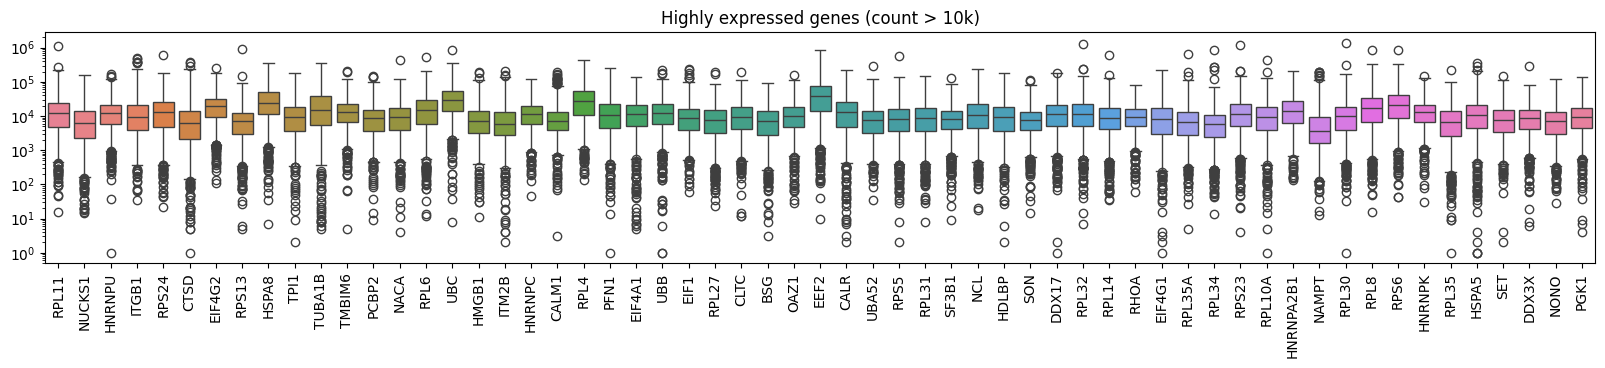

In [16]:
# create a gene: [exp_val1, ..., exp_valn] dict of HK genes with mean exp > 10k
high_mean_hkg = {g.gene_name: g.archs4_cnt for g in hkg if g.get('archs4_mean',None) is not None and g.get('archs4_mean',None) >10000}
# plot
ax = sns.boxplot(data=high_mean_hkg, log_scale=True)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
_ = ax.set_title('Highly expressed genes (count > 10k)')